### XGBoost Model
**program:** 07_xgb_mod_h100<br>
**author:** chris chan<br>
**date:** jan 27,2021<br>
**desc:** use clean df for analysis <br>
**output:** FInal DATAFRAME with prections and probabilities for comparison (99_investigations)
**datasources:**<br>
- sb_analytic (balanced df thru 2010)
- billboard analytic (hot 100 thru 2019)
- spotify random (random thru 2020)

- gridsearch cv: https://towardsdatascience.com/understanding-decision-tree-classification-with-scikit-learn-2ddf272731bd
- model eval : https://towardsdatascience.com/how-to-best-evaluate-a-classification-model-2edb12bcc587
- gradient boosting : https://medium.com/@pushkarmandot/how-exactly-xgboost-works-a320d9b8aeef
- model eval interpretation: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

In [137]:
#######################
# standard code block #
#######################

# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']

#######################
#       imports       #
#######################
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
import xgboost as xgb

sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['randint', 'pylab', 'random', 'std', 'indices', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [138]:
from importlib import reload
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [139]:
import matplotlib.cm as cm
import random

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [140]:
from sqlalchemy import create_engine
import pandas as pd

In [141]:
from sklearn.model_selection import train_test_split

 **1. Bring in data and do light cleaning**

In [142]:
sbdf=pd.read_csv(r'../data/clean/sbdf_clean.csv')
sbdf.head(3)

,SpotifyID,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,loudness,is_hit,year
0,285pBltuF7vW8TeWk8hdRR,0.511,0.566,6,0,0.200,0.3490,0.0,0.340,0.218,83.903,239836,-7.230,1,2018.0
1,7dt6x5M1jzdTEt8oCbisTK,0.680,0.578,10,1,0.040,0.3310,0.0,0.135,0.341,145.038,231267,-5.804,1,2018.0
2,78QR3Wp35dqAhFEc2qAGjE,0.897,0.662,1,0,0.292,0.0852,0.0,0.534,0.389,112.511,145543,-6.903,1,2019.0


In [143]:
sbdf = sbdf[sbdf['year'] >= 1960] 

In [144]:
sbdf.columns = map(str.lower, sbdf.columns)

In [145]:
sbdf['decade'] = (sbdf.year//10*10).astype(int)

In [146]:
sbdf.decade.value_counts()

2000    6239
1990    3864
2010    3829
1980      91
1960       8
1970       4
Name: decade, dtype: int64

In [147]:
sbdf = sbdf[sbdf['decade'] >= 1990] 

In [148]:
sbdf['track_seconds'] = sbdf['duration_ms'] / 1000

In [149]:
sbdf.columns

Index(['spotifyid', 'danceability', 'energy', 'key', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'loudness', 'is_hit', 'year', 'decade', 'track_seconds'],
      dtype='object')

In [306]:
sbdf.shape

(13932, 17)

**Functions for corr matrix and fitting models**

In [150]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import learning_curve


In [308]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (7,5), fontsize=10):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=(7,5))
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="mako") #mako
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('True label',fontsize=14)
    plt.xlabel('Predicted label',fontsize=14)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.tight_layout()
    plt.savefig("xg_confmatrix.png")
    plt.show()
    return fig


In [313]:
#Function used to plot the learning curve, roc curve, and confusing matrix for the given model
def plot_model(model, X, y , X2, y2,threshold=0.5):
    model.fit(X, y)
    y_predict = model.predict(X)
    #y_predictprob = model.predict_proba(X)[:, 1]
    
    y_predictprob = (model.predict_proba(X)[:, 1] >=threshold).astype('int')

    LR_acc = np.round(np.mean(cross_val_score(model, X, y, scoring = 'accuracy', cv = 5)), 5)
    LR_f1 = np.round(np.mean(cross_val_score(model, X, y, scoring = 'f1', cv = 5)), 5)
    LR_prec = np.round(np.mean(cross_val_score(model, X, y, scoring = 'precision', cv = 5)), 5)
    LR_recall = np.round(np.mean(cross_val_score(model, X, y, scoring = 'recall', cv = 5)), 5)
    print(f'The base LR accuracy is: {LR_acc}')
    print(f'The base LR f1 is: {LR_f1}')
    print(f'The base LR precision is: {LR_prec}')
    print(f'The base LR recall is: {LR_recall}')

    #print("train : all metrics:", metrics.classification_report(y,y_predictprob))

    print("Precision: {:6.4f},   Recall: {:6.4f}, Accuracy: {:6.4f}".format(precision_score(y, y_predictprob),
                                                        recall_score(y, y_predictprob) ,
                                                        accuracy_score(y,y_predictprob)))
    
    
    m, train_err, test_err = learning_curve(model, X, y, cv = 5, scoring = 'f1', random_state = 42)
    m_trainerr = np.mean(train_err, axis = 1)
    m_testerr = np.mean(test_err, axis = 1)

    print("train error", m_trainerr.mean(), "test error", m_testerr.mean())
    print("y pred proba ",y_predictprob)
    
    
    # try
    
    ns2_probs = [0 for _ in range(len(y2))]
    y2_predict = model.predict(X2)
    y2_predictprobs = model.predict_proba(X2)[:, 1]
    y2_predictprob = (model.predict_proba(X2)[:, 1]>=threshold).astype('int')
    
    #print("test : all metrics: ", metrics.classification_report(y2,y2_predictprob))    
    print("Precision: {:6.4f},   Recall: {:6.4f}, Accuracy: {:6.4f}, f1: {:6.4f}".format(precision_score(y2, y2_predictprob),
                                                        recall_score(y2, y2_predictprob) ,
                                                        accuracy_score(y2,y2_predictprob),
                                                        f1_score(y2,y2_predictprob)))
    
    
    '''
    connect predictions with outputs for sample probablity
    '''
    global y_pred_prob_df 
    global y_pred_df
    y3_predictprob = (model.predict_proba(X2)[:, 1]) 
    
#     print("X inputs: ", X2[:10], type(X2))
#     print("y predicted prob: ", y3_predictprob[:10], type(y3_predictprob))
#     print("y predicted outcomes: ", y2_predictprob[:10], type(y2_predictprob))
#     print("y actuals: ",y2[:10] , type(y2))
    
    y_pred_prob_df = pd.DataFrame(y3_predictprob,columns=['y_pred_prob'])
    y_pred_df = pd.DataFrame(y2_predictprob,columns=['y_pred'])    
    
    '''
    change array and series to df
    '''
    
    fpr, tpr, thr = roc_curve(y2, y2_predictprobs)
    
    ns2_auc = roc_auc_score(y2, ns2_probs)
    ns2_fpr, ns2_tpr, _ = roc_curve(y2, ns2_probs)

#     optimal_idx = np.argmax(tpr - fpr)
#     optimal_threshold = thresholds[optimal_idx]
#     print("optimal idx", optimal_idx, "optimal threshold", optimal_threshold)
    
    plt.rcParams.update({'figure.figsize': (7, 5)})
#     plt.subplot(1,2,1)
#     plt.plot(m, m_trainerr, 'k', m, m_testerr, 'r')
#     plt.xlabel('Number of Samples', fontsize = 10)
#     plt.ylabel('F1', fontsize = 10)
#     plt.legend(['Training Error', 'Test Error'])
    #plt.subplot(1,2,2)
    
    plt.plot(fpr, tpr)
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {np.round(roc_auc_score(y2, y2_predictprobs), 4)}");

    print(f'AUC: {np.round(roc_auc_score(y2, y2_predictprobs), 4)}')
    
    pyplot.plot(ns2_fpr, ns2_tpr, linestyle='--', label='No Skill')
    plt.tight_layout()
    plt.savefig("xg_aucroc.pdf")
    
    
    conf_mat = confusion_matrix(y2, y2_predictprob)
    cm = print_confusion_matrix(conf_mat, ['not a hit', 'is a hit'])
    
    return y_pred_prob_df 
    return y_pred_df


<br>

## 2. Split Data

In [242]:
# Establishing X and y
y = sbdf['is_hit']
X = sbdf.drop(columns = ['is_hit','spotifyid','decade','year','duration_ms'])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

X2_train, X2_test,  y2_train,y2_test = train_test_split(X_train,y_train, test_size = 0.25, random_state = 42)

In [154]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import pylab
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import itertools


**Model 1 (vanilla)**

The base LR accuracy is: 0.79792
The base LR f1 is: 0.84544
The base LR precision is: 0.79205
The base LR recall is: 0.90681
Precision: 0.8098,   Recall: 0.9280, Accuracy: 0.8232
train error 0.8960519602949425 test error 0.839348778915092
y pred proba  [1 1 0 ... 1 0 1]
Precision: 0.7976,   Recall: 0.9146, Accuracy: 0.8052, f1: 0.8521
AUC: 0.853


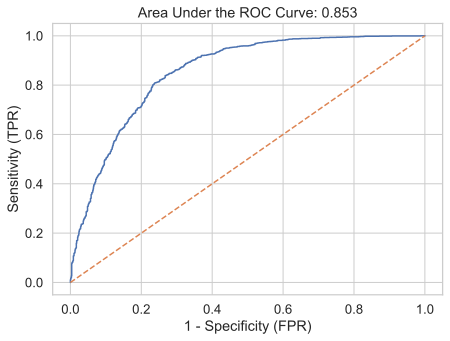

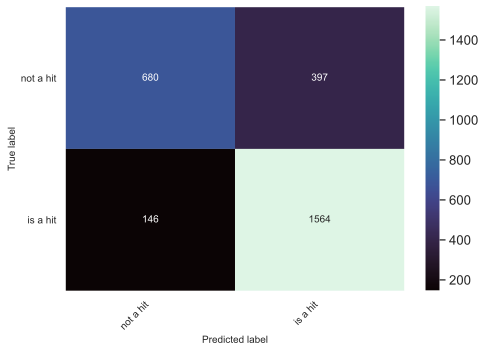

,y_pred_prob
0,0.134395
1,0.612284
2,0.396260
3,0.850095
4,0.764430
...,...
2782,0.851408
2783,0.131603
2784,0.518827
2785,0.925197


In [245]:
xgb_base = GradientBoostingClassifier()
plot_model(xgb_base, X2_train, y2_train, X2_test, y2_test)

**Model tuning**

**Grid search**

In [322]:
# GridSearchCV For Gradient Boosting
grad = GradientBoostingClassifier()
grad_param = {'n_estimators':[100],
              'max_depth':[3,5],
              #'max_features': [6,10],
              #'min_samples_split': [None], 
              #'min_samples_leaf':[3,10],
              'learning_rate': [0.1] #0.0001, 0.001, 0.01, 
             }

grad_grid = GridSearchCV(grad, param_grid=grad_param, cv=3, scoring='f1', verbose=True, n_jobs=-1)

In [323]:
xgb1 = grad_grid.fit(X2_train,y2_train)

grad_ypred = grad_grid.predict(X2_test)

grad_yproba = grad_grid.predict_proba(X2_test)[:,1]

fpr_grad, tpr_grad, _ = roc_curve(y2_test, grad_yproba)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.6s finished


In [324]:
print('best score: ',xgb1.best_score_)
print('best params: ',xgb1.best_params_)

best score:  0.8471277299883191
best params:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


**Fit with best params**

In [158]:
xgb2=GradientBoostingClassifier(                   
                   max_depth=3, 
                   max_features=4,
                   max_leaf_nodes=None,                   
                   #min_samples_leaf=10,
                   n_estimators=100,
                   learning_rate=0.1)

In [159]:
xgb2b = xgb2.fit(X2_train,y2_train)

grad_ypred = xgb2.predict(X2_test)

grad_yproba = xgb2.predict_proba(X2_test)[:,1]

fpr_grad, tpr_grad, _ = roc_curve(y2_test, grad_yproba)

The base LR accuracy is: 0.79923
The base LR f1 is: 0.84645
The base LR precision is: 0.792
The base LR recall is: 0.90877
Precision: 0.8081,   Recall: 0.9260, Accuracy: 0.8208
train error 0.8897876515210944 test error 0.8400026393748845
y pred proba  [1 1 0 ... 1 0 1]
Precision: 0.7959,   Recall: 0.9146, Accuracy: 0.8037, f1: 0.8512
AUC: 0.851


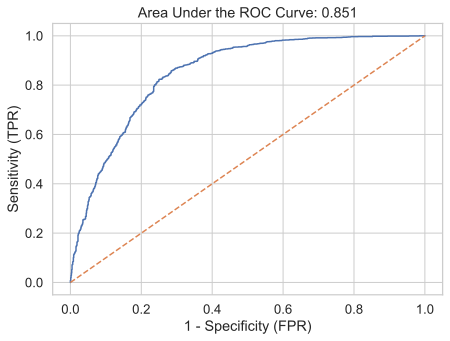

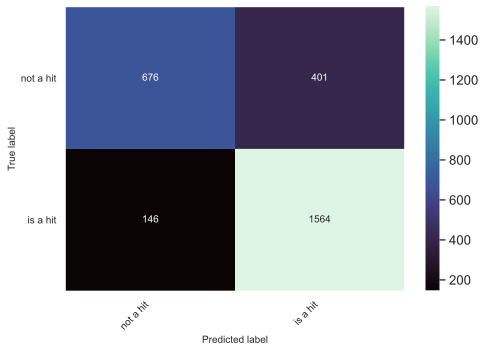

,y_pred_prob
0,0.247601
1,0.603988
2,0.386401
3,0.846959
4,0.867951
...,...
2782,0.832179
2783,0.166836
2784,0.599636
2785,0.927571


In [235]:
plot_model(xgb2, X2_train, y2_train, X2_test, y2_test)

<br>

**Feature Importance**

[ 3  2  9  4  1  7  8  0 11 10  5  6]
Index(['mode', 'key', 'tempo', 'speechiness', 'energy', 'liveness', 'valence',
       'danceability', 'track_seconds', 'loudness', 'acousticness',
       'instrumentalness'],
      dtype='object')
1. feature 3 (0.000525)
2. feature 2 (0.002024)
3. feature 9 (0.012749)
4. feature 4 (0.017963)
5. feature 1 (0.018811)
6. feature 7 (0.019719)
7. feature 8 (0.058188)
8. feature 0 (0.082332)
9. feature 11 (0.125653)
10. feature 10 (0.131437)
11. feature 5 (0.151289)
12. feature 6 (0.379311)


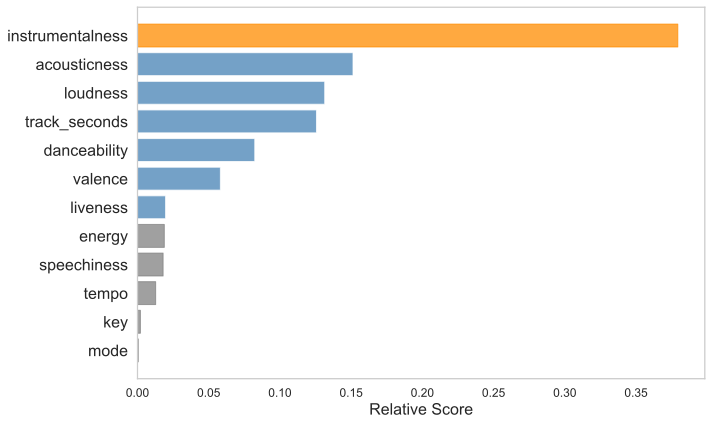

In [331]:
#matplotlib.use('tkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

feature_names = X2_train.columns

flist2 = grad_grid.best_estimator_.feature_importances_

std=np.std([flist2 for tree in grad_grid.best_estimator_.estimators_],axis=0)
indices = np.argsort(flist2)[::]

print(indices)

ls=feature_names[indices]
print(ls)

# Print the feature ranking
# print("Feature ranking:")
for f in range(X2_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f] , flist2[indices[f]])) 

# Plot the impurity-based feature importances of the forest
ax=plt.figure(figsize=(10,6))


#ax = fig.add_subplot(221, polar=True)    
plt.grid(b=None)
#plt.title("Feature importances")
# barlist=plt.bar(range(X2_train.shape[1]), flist2[indices],
#         color="lightblue", yerr=std[indices], align="center",alpha=0.85)

barlist=plt.barh(range(X2_train.shape[1]),flist2[indices],
    color="steelblue", yerr=std[indices], align="center",alpha=0.75)

plt.yticks(range(X2_train.shape[1]), ls ,rotation=0,fontsize=16) #indices)

plt.xticks(fontsize=12) #indices)
plt.xlabel('Relative Score', fontsize=16)
#plt.xlim([-1, X2_train.shape[1]])
plt.gcf().subplots_adjust(bottom=0.15)
plt.tight_layout()
barlist[-1].set_color('darkorange')

for i in range(0,5):
    barlist[i].set_color('grey')
#barlist[1].set_color('grey')
plt.savefig("xg_featimportance.pdf")
plt.show()

<br>

**Refitting based on dropped columns**

In [309]:
X3_train = X2_train.drop(['tempo','mode','key','speechiness','energy'], axis = 1)
X3_test = X2_test.drop(['tempo','mode','key','speechiness','energy'], axis = 1)
# rlr_secondf1 = plot_model(lr, lr_Xtrain, y2_train, X2_test, y2_test)

The base LR accuracy is: 0.79481
The base LR f1 is: 0.8439
The base LR precision is: 0.79249
The base LR recall is: 0.90563
Precision: 0.8052,   Recall: 0.9245, Accuracy: 0.8175
train error 0.8868304741181007 test error 0.8392015864553422
y pred proba  [1 1 0 ... 1 0 1]
Precision: 0.7948,   Recall: 0.9105, Accuracy: 0.8009, f1: 0.8487
AUC: 0.8489


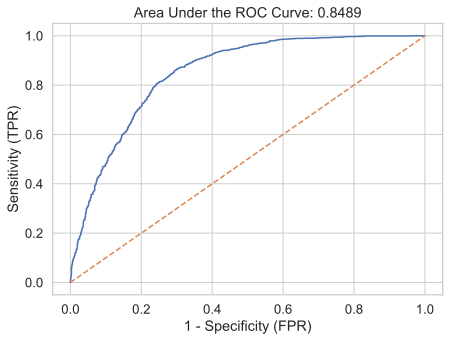

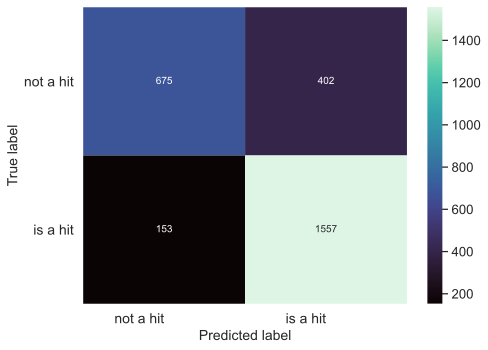

,y_pred_prob
0,0.141093
1,0.629371
2,0.483699
3,0.847864
4,0.860497
...,...
2782,0.842598
2783,0.155910
2784,0.515110
2785,0.923042


In [310]:
plot_model(xgb2, X3_train, y2_train, X3_test, y2_test)

<br>

**Changing threshold to bring precision up**

The base LR accuracy is: 0.79672
The base LR f1 is: 0.84458
The base LR precision is: 0.79053
The base LR recall is: 0.90484
Precision: 0.8433,   Recall: 0.8193, Accuracy: 0.7970
train error 0.8869810441767904 test error 0.8388003950521867
y pred proba  [1 1 0 ... 0 0 1]
Precision: 0.8377,   Recall: 0.8088, Accuracy: 0.7865, f1: 0.8230
AUC: 0.8499


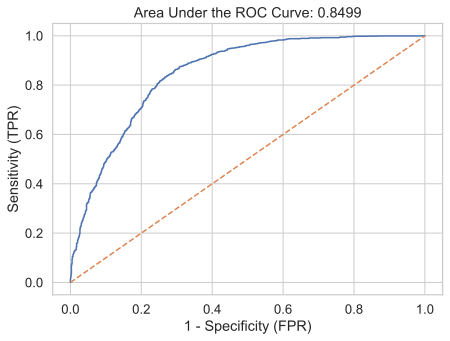

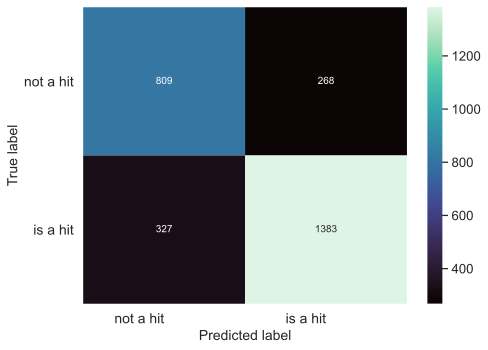

,y_pred_prob
0,0.150900
1,0.611076
2,0.425166
3,0.843218
4,0.852016
...,...
2782,0.861309
2783,0.120022
2784,0.456594
2785,0.915121


In [311]:
plot_model(xgb2, X3_train, y2_train, X3_test, y2_test, 0.66)

<br>

**FINAL MODEL on HOLDOUT TEST. Threshold 0.66 to capture more precision without losing much recall and accuracy**

In [243]:
X_test = X_test.drop(['tempo','mode','key','speechiness','energy'], axis = 1)

The base LR accuracy is: 0.7948
The base LR f1 is: 0.84297
The base LR precision is: 0.79053
The base LR recall is: 0.90504
Precision: 0.8463,   Recall: 0.8221, Accuracy: 0.8004
train error 0.8869715148485773 test error 0.8393047559862007
y pred proba  [1 1 0 ... 1 0 1]
Precision: 0.8282,   Recall: 0.7961, Accuracy: 0.7747, f1: 0.8119
AUC: 0.8502


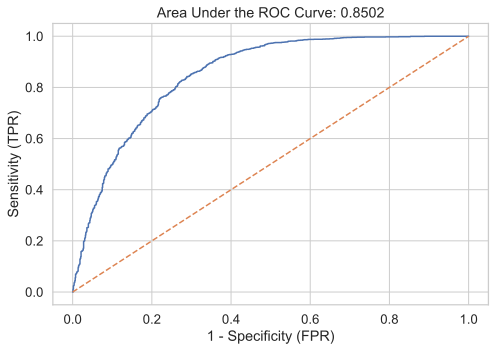

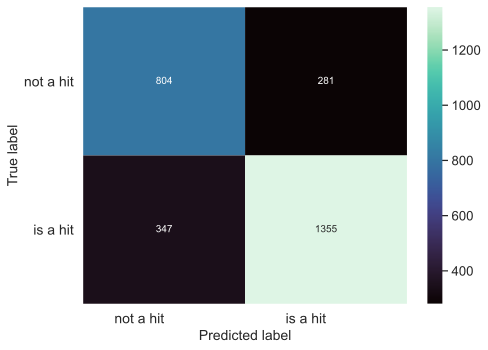

,y_pred_prob
0,0.805269
1,0.907362
2,0.824638
3,0.018964
4,0.056070
...,...
2782,0.881488
2783,0.802697
2784,0.282408
2785,0.852738


In [314]:
# rlr_secondf1 = plot_model(lr, lr_Xtrain, y2_train, X2_test, y2_test)
plot_model(xgb2, X3_train, y2_train, X_test, y_test, 0.66)

<br>

**Create DF for predicted prob/outcomes and merge back to orig df**

In [106]:
y_pred_prob_df['row_num']= np.arange(len(y_pred_prob_df))
y_pred_df['row_num']= np.arange(len(y_pred_df))
X_test['row_num']= np.arange(len(X_test))
y_test_df = y_test.to_frame()
y_test_df['m_index'] = y_test_df.index
#y_test_df2=y_test_df.rename_axis('m_index')
y_test_df['row_num']= np.arange(len(y_test_df))

In [107]:
from functools import reduce
data_frames=[X_test,y_test_df,y_pred_df,y_pred_prob_df]
m_results = reduce(lambda left,right: pd.merge(left,right,on=['row_num'], how='outer'),data_frames)

In [108]:
m_results.head(10)

,danceability,acousticness,instrumentalness,liveness,valence,loudness,track_seconds,row_num,is_hit,m_index,y_pred,y_pred_prob
0,0.740,0.26700,0.000000,0.1020,0.8680,-3.877,181.227,0,0,12356,1.0,0.831481
1,0.678,0.00583,0.000000,0.1090,0.4120,-4.399,284.000,1,1,8465,1.0,0.905922
2,0.469,0.27500,0.000000,0.2840,0.2500,-10.681,305.933,2,1,5987,1.0,0.827594
3,0.189,0.81400,0.871000,0.1110,0.0352,-14.195,186.040,3,0,10610,0.0,0.027309
4,0.491,0.07070,0.866000,0.0669,0.5060,-13.069,351.787,4,0,12899,0.0,0.055365
5,0.589,0.02420,0.000000,0.1180,0.2510,-5.288,223.973,5,1,7331,1.0,0.914128
6,0.389,0.41700,0.000000,0.1710,0.3810,-7.111,356.133,6,1,2277,1.0,0.785158
7,0.850,0.16500,0.000000,0.1000,0.8840,-5.828,260.840,7,0,9694,1.0,0.799261
8,0.806,0.00496,0.000001,0.1600,0.2600,-6.538,251.333,8,1,7211,1.0,0.893315
9,0.379,0.99400,0.000071,0.0910,0.0735,-17.362,192.240,9,0,9438,0.0,0.175326


**assign column index to merge to new results**

In [109]:
sbdf['m_index'] = sbdf.index

**create final test df with results for comparison**

In [110]:
# merge results back to real data
final_df = pd.merge(sbdf,m_results,left_on='m_index',right_on='m_index')

In [113]:
final_df.head()
#final_df.shape

(2787, 29)

**output csv**

In [116]:
final_df.to_csv(r'sb_final_df.csv', index = False)

**test song**
danceability	energy	key	loudness	mode	speechiness	acousticness	instrumentalness	liveness	valence	tempo	time_signature	year	track_seconds
0.513	0.796	1	-4.075	1	0.0629	0.00147	0.000209	0.0938	0.345	171.017	4	2019	201.573